# Network Analysis Lab

Complete the following exercises to help solidify your understanding of network analysis.

In [1]:
%%capture
!pip install nxviz --user

In [13]:
import networkx as nx
import nxviz
import community

from itertools import combinations

In [14]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## U.S. Mens Basketball Data Set

In the `us_mens_basketball.csv` data set, each row represents an single basketball player's participation in a single event at a single Olympics. 

In [15]:
basketball = pd.read_csv('../data/us_mens_basketball.csv')

In [16]:
basketball.head(2)

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,351,Julius Shareef Abdur-Rahim,M,23.0,202.0,104.0,United States,USA,2000 Summer,2000,Summer,Sydney,Basketball,Basketball Men's Basketball,Gold
1,2636,"Stephen Todd ""Steve"" Alford",M,19.0,185.0,74.0,United States,USA,1984 Summer,1984,Summer,Los Angeles,Basketball,Basketball Men's Basketball,Gold


In [17]:
basketball.shape

(222, 15)

## 1. Transform this data set into one that can be turned into a graph where the entities are represented by the Name field and the relationships are represented by whether the players played in the same Olympics together (Games field).

Sort descending by the number of pairwise interactions. Which pair of players have competed in the most Olympics together?

In [18]:
def df_to_graph(df, entity, edge):
    df2 = df.copy()
    graph_df = pd.merge(df, df2, how='inner', on=edge)
    graph_df = graph_df.groupby([entity + '_x', entity + '_y']).count().reset_index()
    graph_df = graph_df[graph_df[entity + '_x'] != graph_df[entity + '_y']]
    
    if type(edge) == list:
        graph_df = graph_df[[entity + '_x', entity + '_y'] + edge]
    else:
        graph_df = graph_df[[entity + '_x', entity + '_y', edge]]
    
    return graph_df


In [19]:
df_basket = df_to_graph(basketball, 'Name', 'Games')
df_basket.sample(5)

,Name_x,Name_y,Games
2513,Willard Theodore Schmidt,Duane Alexander Swanson,1
427,"Christopher Paul ""Chris"" Mullin",Karl Malone,1
2582,"William John ""Bill"" Wheatley","Joseph Cephis ""Joe"" Fortenberry",1
1668,"Michael Allen ""Mike"" Bantom","William Edward ""Ed"" Ratleff",1
877,Gordon C. Carpenter,"Ralph Milton Beard, Jr.",1


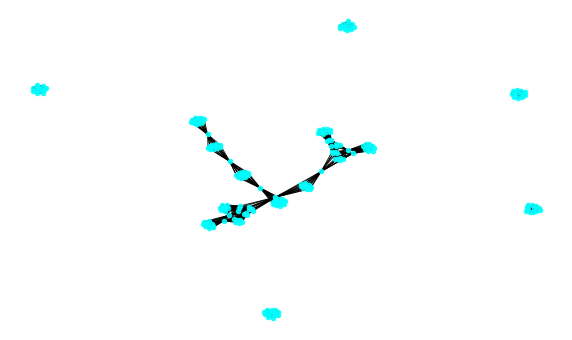

In [41]:
plt.figure(figsize=(10, 6))
plt.axis('off')

nx.draw(G, node_size=20, node_color = 'Cyan', font_color='k', alpha=0.9, font_size=18)

## 2. Use the `from_pandas_edgelist` method to turn the data frame into a graph.

In [24]:
G = nx.from_pandas_edgelist(df_basket, source= 'Name_x', target='Name_y')
G

## 3. Compute and print the following graph statistics for the graph:

- Number of nodes
- Number of edges
- Average degree
- Density

In [25]:
print(G.number_of_nodes())
print(G.number_of_edges())
print(nx.density(G))



196
1232
0.06446886446886448


In [13]:
print(dir(G))

['__class__', '__contains__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__getitem__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__iter__', '__le__', '__len__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', '_adj', '_node', 'add_edge', 'add_edges_from', 'add_node', 'add_nodes_from', 'add_weighted_edges_from', 'adj', 'adjacency', 'adjlist_inner_dict_factory', 'adjlist_outer_dict_factory', 'clear', 'clear_edges', 'copy', 'degree', 'edge_attr_dict_factory', 'edge_subgraph', 'edges', 'get_edge_data', 'graph', 'graph_attr_dict_factory', 'has_edge', 'has_node', 'is_directed', 'is_multigraph', 'name', 'nbunch_iter', 'neighbors', 'node_attr_dict_factory', 'node_dict_factory', 'nodes', 'number_of_edges', 'number_of_nodes', 'order', 'remove_edge', 'remove_edges_from', 'remove_node', 'remove_nodes_from', 'si

## 4. Compute betweenness centrality for the graph and print the top 5 nodes with the highest centrality.

In [26]:
vals = []
for k,v in nx.betweenness_centrality(G).items():
    vals.append((k,v))
    
top_betweenness= sorted(vals, key=lambda x: -x[1])
top_betweenness[:5]


[('Gary Dwayne Payton', 0.09193761564895586),
 ('Jason Frederick Kidd', 0.09135606661379858),
 ('Carmelo Kyan Anthony', 0.04742268041237115),
 ('David Maurice Robinson', 0.03266190853819722),
 ('William Marion "Bill" Hougland', 0.030240549828178694)]

## 5. Compute Eigenvector centrality for the graph and print the top 5 nodes with the highest centrality.

In [27]:
vals = []
for k,v in nx.eigenvector_centrality(G).items():
    vals.append((k,v))
    
top_betweenness= sorted(vals, key=lambda x: -x[1])
top_betweenness[:5]


PowerIterationFailedConvergence: (PowerIterationFailedConvergence(...), 'power iteration failed to converge within 100 iterations')

## 6. Compute degree centrality for the graph and print the top 5 nodes with the highest centrality.

In [28]:
vals = []
for k,v in nx.degree_centrality(G).items():
    vals.append((k,v))
    
top_betweenness= sorted(vals, key=lambda x: -x[1])
top_betweenness[:5]

[('Carmelo Kyan Anthony', 0.18461538461538463),
 ('David Maurice Robinson', 0.14358974358974358),
 ('Robert Albert "Bob" Kurland', 0.13333333333333333),
 ('LeBron Raymone James', 0.13333333333333333),
 ('William Marion "Bill" Hougland', 0.12307692307692308)]

## 7. Generate a network visualization for the entire graph using a Kamada-Kawai force-directed layout.

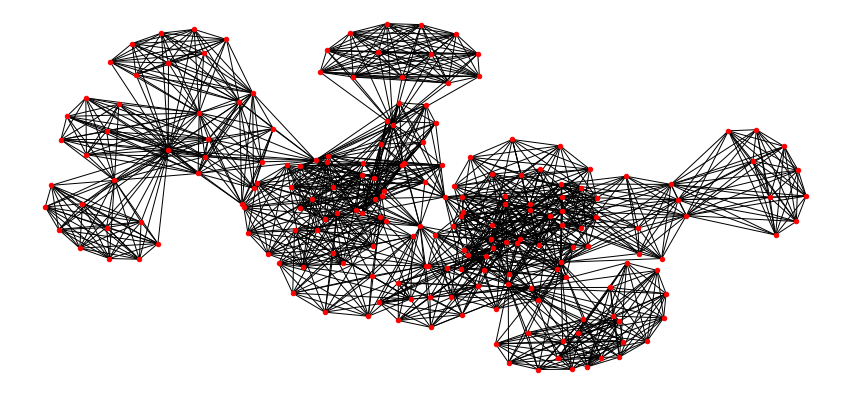

In [29]:
plt.figure(figsize=(15,7))
plt.axis('off')

nx.draw_kamada_kawai(G, node_size=20, node_color='red')

## 8. Create and visualize an ego graph for the player with the highest betweenness centrality.

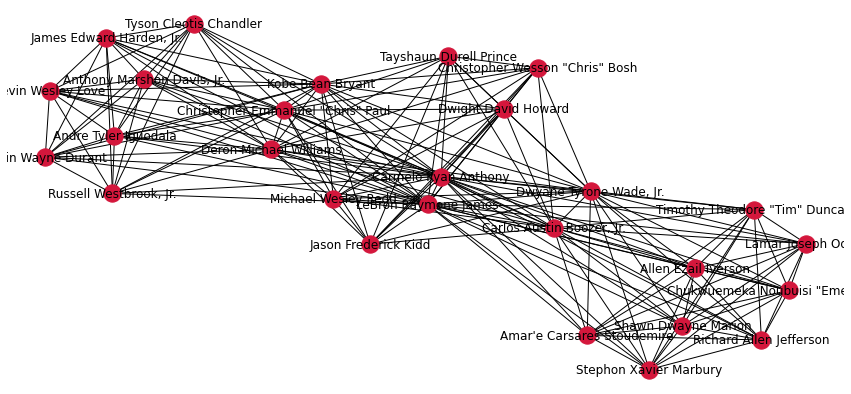

In [39]:
plt.figure(figsize=(15,7))
plt.axis('off')

highest_betweenness_ego = nx.ego_graph(G,'LeBron Raymone James')
pos = nx.spring_layout(highest_betweenness_ego)

nx.draw_networkx(highest_betweenness_ego, pos=pos,node_color='#d4173c')


## 9. Identify the communities within the entire graph and produce another visualization of it with the nodes color-coded by the community they belong to.

## Bonus: Hierarchical Graphs

Thus far, we have analyzed graphs where the nodes represented individual players and the edges represented Olympic games that they have competed in together. We can analyze the data at a higher level if we wanted to, strippping out the players as entities and analyzing the data at the Games level. To do this, we would need to reconstruct the graph so that the *Games* field represents the entities and then use the player names as the edge criteria so that there would be an edge between two Olympic games if an player played in both of them. You already have the tools in your toolbox to be able to do this, so give it a try. 

### Create a graph with Games as the entities and then print out the graph statistics.

### Generate a network visualization of this graph using the layout of your choice.